In [34]:
import os
import numpy as np
from matplotlib import pyplot as plt
import fiona
import rasterio
from rasterio.tools.mask import mask
import json
from pprint import pprint
from scipy.misc import bytescale
from skimage import exposure

%matplotlib inline

# define a function to add a colorbar of nice height
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

## Landsat 8 OLI

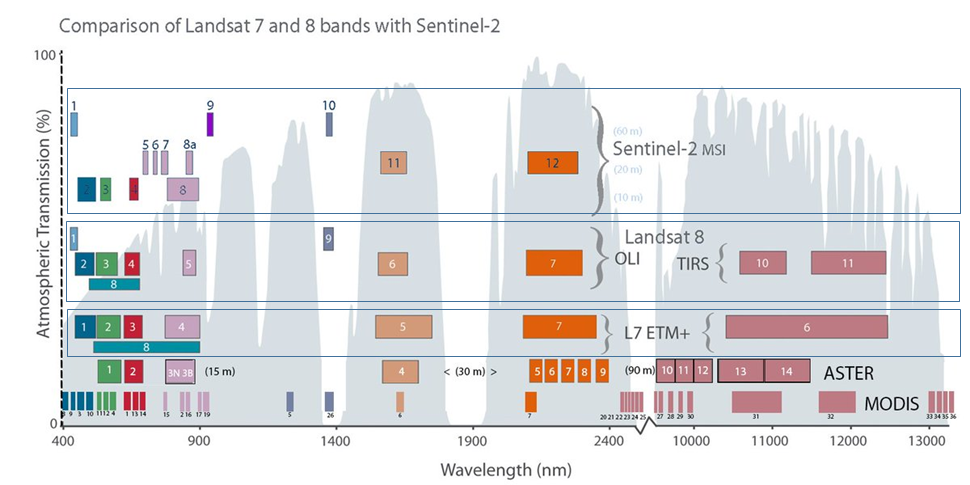

In [2]:
## we will pick a scene over the front range. Check out the files in the folder on AWS
aws_scene_path = 'landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1'
!aws s3 ls $aws_scene_path/ --no-sign-request

2018-06-05 23:05:07     117266 LC08_L1TP_034032_20180526_20180605_01_T1_ANG.txt
2018-06-05 23:04:50   64543762 LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF
2018-06-05 23:04:52    8291279 LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF.ovr
2018-06-05 23:04:37   58906434 LC08_L1TP_034032_20180526_20180605_01_T1_B10.TIF
2018-06-05 23:04:52    8326690 LC08_L1TP_034032_20180526_20180605_01_T1_B10.TIF.ovr
2018-06-05 23:04:36      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B10_wrk.IMD
2018-06-05 23:04:54   57516650 LC08_L1TP_034032_20180526_20180605_01_T1_B11.TIF
2018-06-05 23:04:41    8174375 LC08_L1TP_034032_20180526_20180605_01_T1_B11.TIF.ovr
2018-06-05 23:04:42      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B11_wrk.IMD
2018-06-05 23:04:36      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B1_wrk.IMD
2018-06-05 23:05:06   65529406 LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF
2018-06-05 23:04:56    8405569 LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF.ovr
2018-06-05 23:04:

# since we don't have AWSCLI configured, we will need to download the data before we can load it.

In [3]:
scene_base = os.path.basename(aws_scene_path) # all after last slash
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'] # need these for the file paths

# specify an output directory to hold the files. create it if it doesn't exist
L8_dir = 'data_L8'
if not os.path.exists(L8_dir):
    os.mkdir(L8_dir)

# iterate through the bands list to download the data
for band in bands:
    sample_band = aws_scene_path + '/{}_{}.TIF'.format(scene_base, band)
    s3_path = "s3://{}".format(sample_band)
    print(s3_path)
    
    # copy from S3 if not done already
    if not os.path.exists(L8_dir + '/{}_{}.TIF'.format(scene_base, band)):
        !aws s3 cp $s3_path $L8_dir --no-sign-request
    

s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B3.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B4.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B5.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B6.TIF
s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B7.TIF


# also get the json file, to view the metadata

In [4]:
# download the JSON file if it doesn't exist already
json_path = 's3://' + aws_scene_path + '/{}_MTL.json'.format(scene_base)

if not os.path.exists(L8_dir + '/{}_MTL.json'.format(scene_base)):
    !aws s3 cp $json_path $L8_dir --no-sign-request

In [5]:
# load the file
local_mtl = L8_dir + '/{}_MTL.json'.format(scene_base)

with open(local_mtl, 'r') as f:
    mtl = json.load(f)
    
# show it with pretty print    
pprint(mtl)

{'L1_METADATA_FILE': {'IMAGE_ATTRIBUTES': {'CLOUD_COVER': 3.36,
                                           'CLOUD_COVER_LAND': 3.36,
                                           'EARTH_SUN_DISTANCE': 1.0130559,
                                           'GEOMETRIC_RMSE_MODEL': 7.082,
                                           'GEOMETRIC_RMSE_MODEL_X': 4.869,
                                           'GEOMETRIC_RMSE_MODEL_Y': 5.143,
                                           'GEOMETRIC_RMSE_VERIFY': 3.313,
                                           'GROUND_CONTROL_POINTS_MODEL': 427,
                                           'GROUND_CONTROL_POINTS_VERIFY': 111,
                                           'GROUND_CONTROL_POINTS_VERSION': 4,
                                           'IMAGE_QUALITY_OLI': 9,
                                           'IMAGE_QUALITY_TIRS': 9,
                                           'ROLL_ANGLE': -0.001,
                                           'SATURATI

# now that the GeoTIFFs are downloaded, load them into a raster stack
We will subset it by an AOI

In [16]:
# this code reads in the geometry attribute for the AOI
with fiona.open("shp/aoi.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

# we will read in the images band by band and subset it by the AOI
band_arrs = [] # empty list to store the data arrays
for band in bands:
    sample_band = L8_dir + '/{}_{}.TIF'.format(scene_base, band)
    with rasterio.open(sample_band, 'r') as src:
        arr, prof = mask(src, geoms, crop=True)
        
        
    band_arrs.append(arr.squeeze()) # use the .squeeze() method to remove singleton dimension
    
# then convert to numpy array, and delete the list
arr_L8 = np.array(band_arrs)
del band_arrs

# mask the nodata
# arr_L8 = np.ma.masked_equal(rgb_arr, 0)

# print the shape of the full array
print('Image Dimensions: {}'.format(arr_L8.shape))

Image Dimensions: (7, 501, 501)


In [21]:
# take a look at the Affine transform for the cropped image
print(prof)
prof

| 30.00, 0.00, 402645.00|
| 0.00,-30.00, 4488795.00|
| 0.00, 0.00, 1.00|


Affine(30.0, 0.0, 402645.0,
       0.0, -30.0, 4488795.0)

In [22]:
# get the extent of the image
xmin = prof.c
ymin = prof.f + prof.e*arr_L8.shape[1] # rows
xmax = prof.c + prof.a*arr_L8.shape[2] # columns
ymax = prof.f
extent = [xmin, ymin, xmax, ymax]



C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


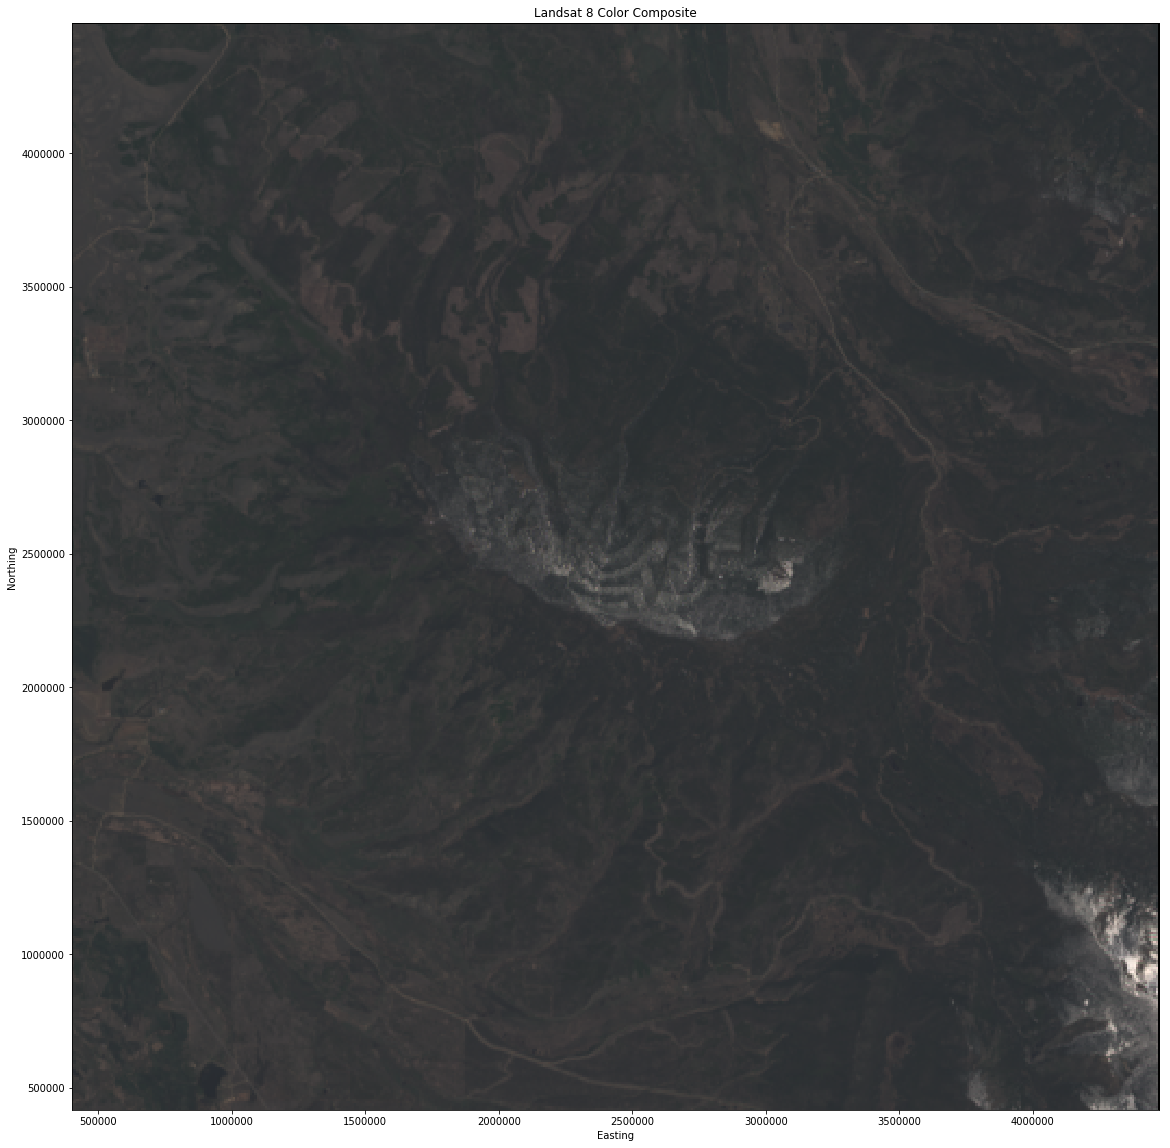

In [24]:
# slice the full array for RGB channels
cir = [4,3,2]
rgb = [3,2,1]
rgb_arr = arr_L8[rgb, :, :]
rgb_arr = np.rollaxis(rgb_arr, 0, 3) # need channel axis to be last for plotting
rgb_arr_ma = np.ma.masked_equal(rgb_arr, 0)

# plot the image
fig, ax = plt.subplots(figsize=(20,20))
plt.title('Landsat 8 Color Composite')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.imshow(bytescale(rgb_arr), extent=extent);

# Let's take a look at the individual bands. There may not be good contrast in some of the bands so we will also apply contrast stretching to the bands.

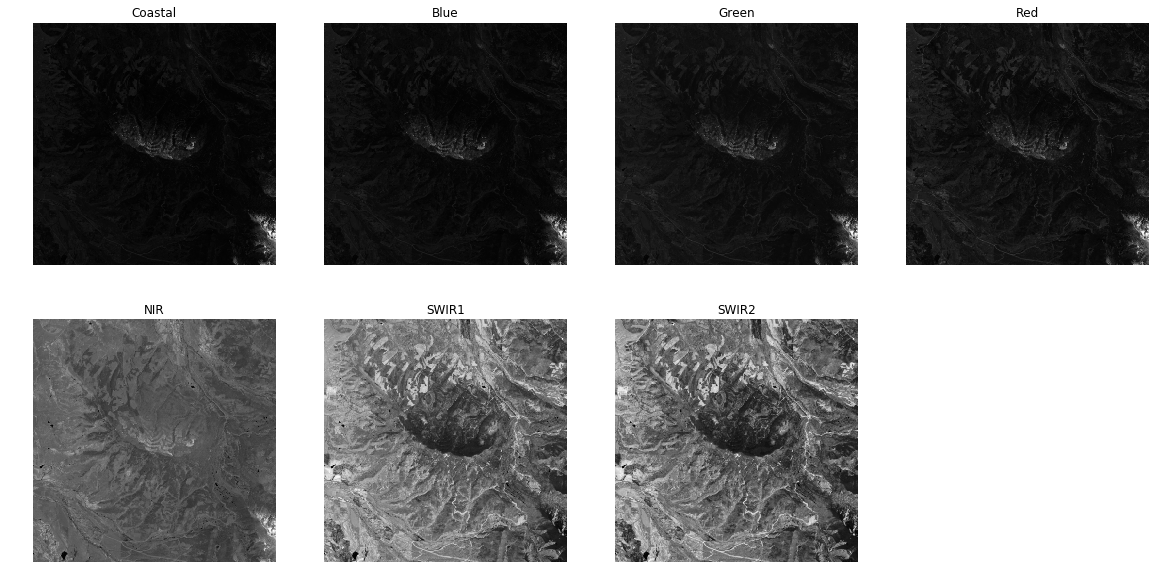

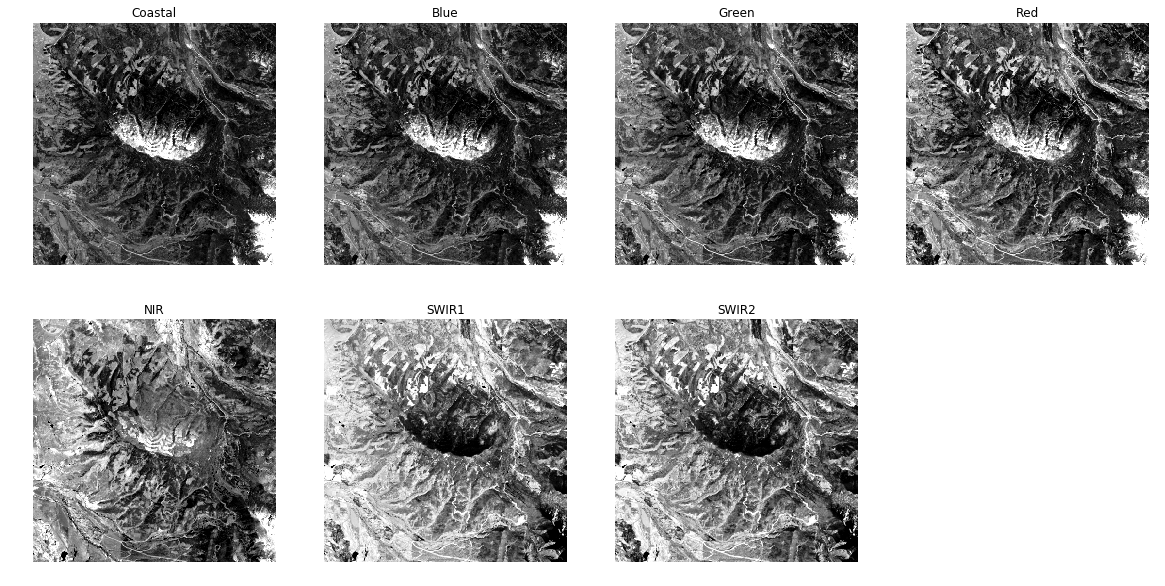

In [37]:
# plot the bands
plt.figure(figsize=(20,10))
channels = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'] # used for plot titles
for i in range(arr_L8.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plot_band = np.ma.masked_equal(arr_L8[i], 0)
    plt.imshow(plot_band, cmap="Greys_r")
    plt.title(channels[i])
plt.show()

# do it again with contrast enhancement
plt.figure(figsize=(20,10))
for i in range(arr_L8.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plot_band = np.ma.masked_equal(arr_L8[i], 0)
    
    # contrast enhancement
    p2, p98 = np.percentile(plot_band, (2, 98))
    img_rescale = exposure.rescale_intensity(plot_band, in_range=(p2, p98))
    
    plt.imshow(img_rescale, cmap="Greys_r")
    plt.title(channels[i])
plt.show()



## Vegetation Index and Chromaticity

Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). The equation we will be using to calculate NDVI is:

\begin{equation*}
NDVI = \frac{NIR - RED}{NIR + RED}
\end{equation*}


Chromaticity is an objective specification of the quality of a color regardless of its luminance. Here we specify the Blue, Green, Red, and NIR channels as colors to calculate their chromaticity.

\begin{equation*}
blue_{chromaticity} = \frac{BLUE}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
green_{chromaticity} = \frac{GREEN}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
red_{chromaticity} = \frac{RED}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
nir_{chromaticity} = \frac{NIR}{BLUE + GREEN + RED + NIR}
\end{equation*}

ndvi min/max: -0.13046346693056243 / 0.5461041810317808
c_red min/max: 0.14794703460554134 / 0.2765679602722089


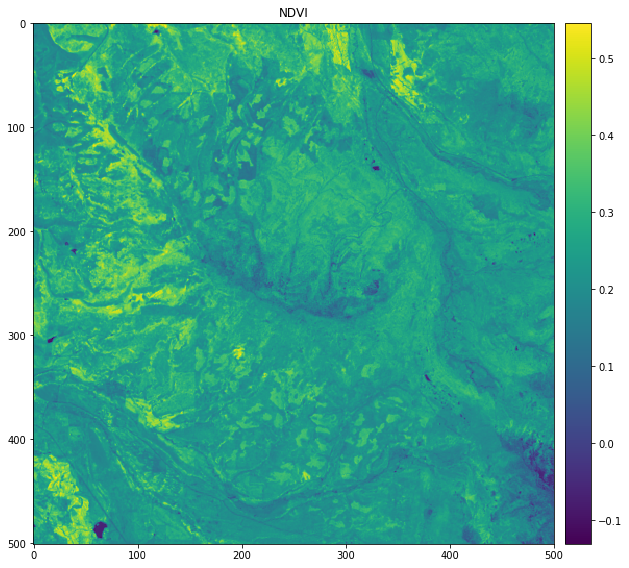

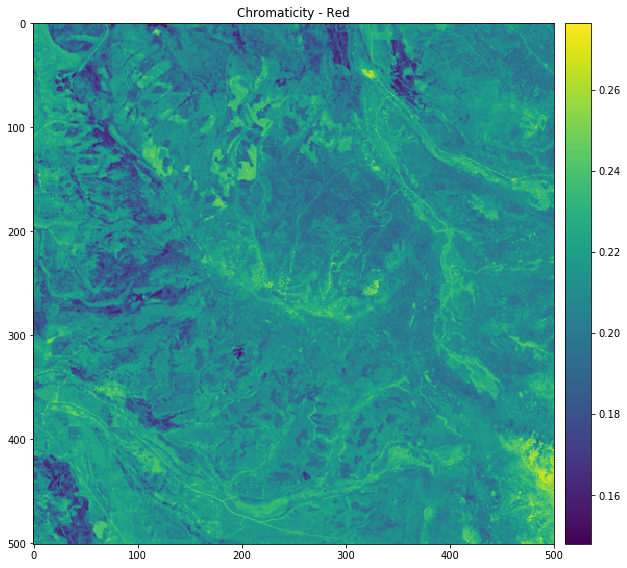

In [39]:
# subset the bands as necessary
blue = arr_L8[1,:,:].astype(np.float)
green = arr_L8[2,:,:].astype(np.float)
red = arr_L8[3,:,:].astype(np.float)
nir = arr_L8[4,:,:].astype(np.float)

# mask them
blue = np.ma.masked_equal(blue,0)
red = np.ma.masked_equal(red,0)
nir = np.ma.masked_equal(nir,0)

# define NDVI..  maybe look at some stats?
ndvi = (nir - red) / (nir + red)
print('ndvi min/max: {} / {}'.format(ndvi.min(), ndvi.max()))

# define a chromaticity coordinate..  maybe look at some stats?
c_red = red / (blue + green + red + nir)
print('c_red min/max: {} / {}'.format(c_red.min(), c_red.max()))

fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(ndvi) # change cmap
ax.set_title('NDVI')
colorbar(cf)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(c_red) # change cmap
ax.set_title('Chromaticity - Red')
colorbar(cf)

plt.show()


## use scikit learn for clustering on all 7 bands and then b/g/r/nir chromaticity bands. compare


C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


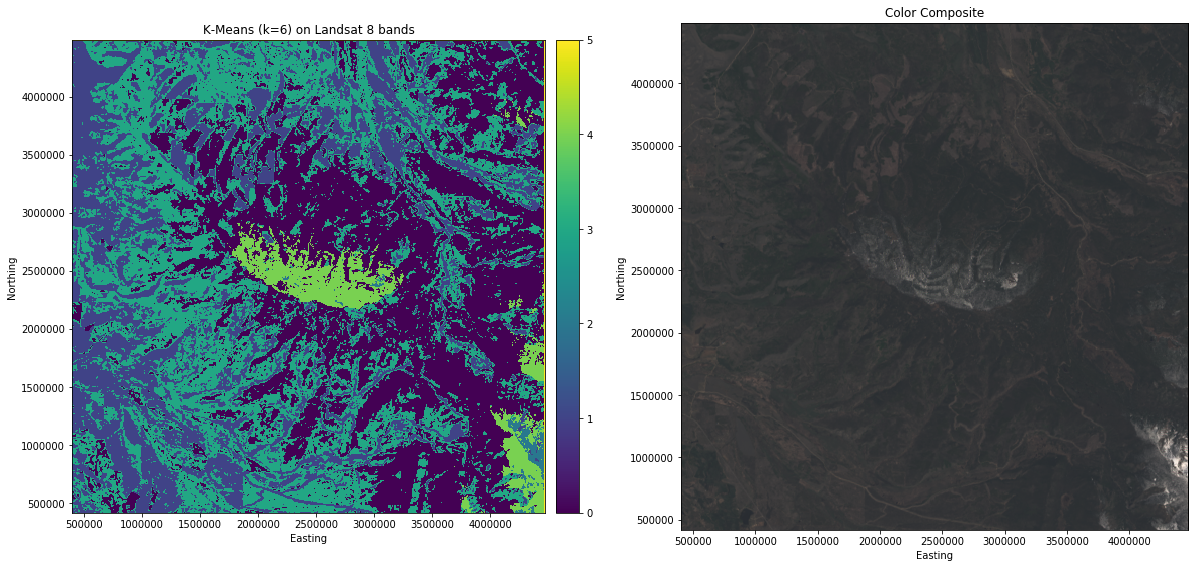

In [45]:
from sklearn.cluster import KMeans

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(arr_L8, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# fit the classifier
labels_test_im = clf.fit_predict(X, y=None)

# reshape the labels to the image size
labels_test_im_arr = np.reshape(labels_test_im, (arr_L8.shape[1], arr_L8.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
cf = ax[0].imshow(labels_test_im_arr, extent=extent)
colorbar(cf)
ax[0].set_title('K-Means (k={}) on Landsat 8 bands'.format(n_clusters))
ax[0].set_xlabel('Easting')
ax[0].set_ylabel('Northing')
ax[1].imshow(bytescale(rgb_arr), extent=extent)
ax[1].set_title('Color Composite')
ax[1].set_xlabel('Easting')
ax[1].set_ylabel('Northing')
plt.show()

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:34: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


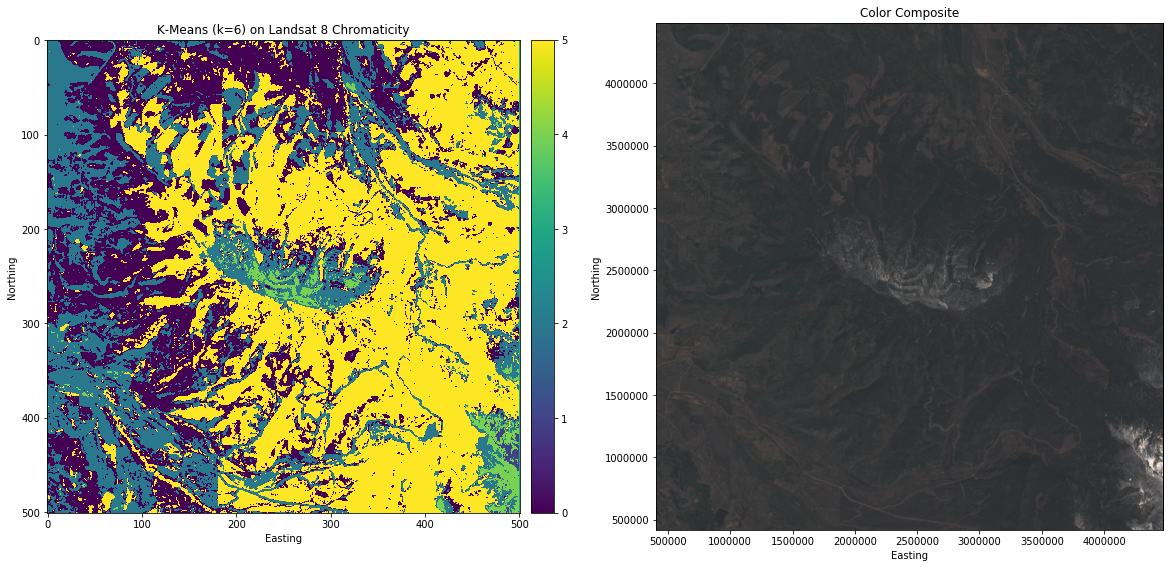

In [47]:
## look at it for chromaticity

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(arr_L8, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# use only the Blue/Green/Red/NIR channels
Xc = X[:, [1,2,3,4]]

# normalize by the sum to get chromaticity
Xc = Xc / Xc.sum(axis=0)


# fit the classifier
labels_test_chrom = clf.fit_predict(Xc, y=None)

# reshape the labels to the image size
labels_test_chrom_arr = np.reshape(labels_test_chrom, (arr_L8.shape[1], arr_L8.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
cf = ax[0].imshow(labels_test_chrom_arr)
colorbar(cf)
ax[0].set_title('K-Means (k={}) on Landsat 8 Chromaticity'.format(n_clusters))
ax[0].set_xlabel('Easting')
ax[0].set_ylabel('Northing')
ax[1].imshow(bytescale(rgb_arr), extent=extent)
ax[1].set_title('Color Composite')
ax[1].set_xlabel('Easting')
ax[1].set_ylabel('Northing')
plt.show()

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:30: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


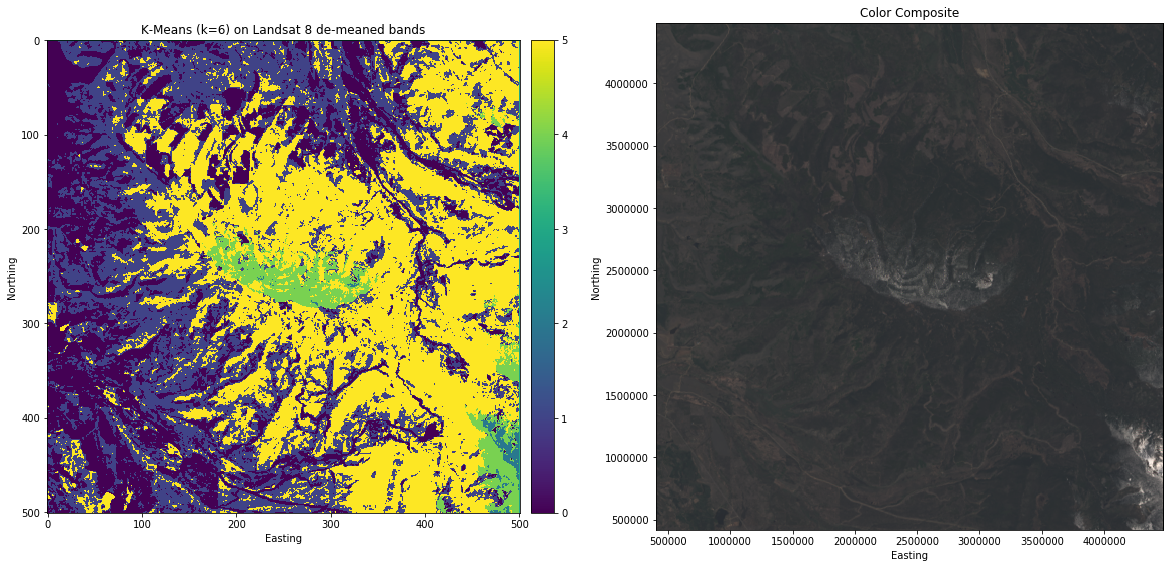

In [49]:
## look at it for normalizing by mean and standard deviation

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(arr_L8, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# normalize by the mean and standard deviation
Xc = (X-X.mean(axis=0)) / X.std(axis=0)

# fit the classifier
labels_test_demean = clf.fit_predict(Xc, y=None)

# reshape the labels to the image size
labels_test_demean_arr = np.reshape(labels_test_demean, (arr_L8.shape[1], arr_L8.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
cf = ax[0].imshow(labels_test_demean_arr)
colorbar(cf)
ax[0].set_title('K-Means (k={}) on Landsat 8 de-meaned bands'.format(n_clusters))
ax[0].set_xlabel('Easting')
ax[0].set_ylabel('Northing')
ax[1].imshow(bytescale(rgb_arr), extent=extent)
ax[1].set_title('Color Composite')
ax[1].set_xlabel('Easting')
ax[1].set_ylabel('Northing')
plt.show()

## Let's look for a Sentinel-2 scene over the same AOI
## Sentinel-2 data should have the following co-registered bands:
 
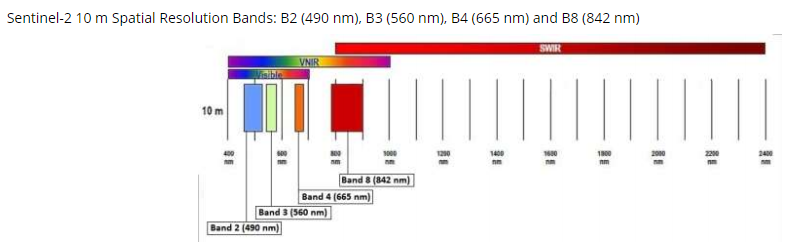
 

The Sentinel-2 tile ID that intersects our AOI is 13TDE. The date of the Landsat scene acquisition is 2018-05-26, and the closest cloud-free Sentinel-2 scene was captured on 2018-06-01.

In [51]:
!aws s3 ls sentinel-s2-l1c/tiles/13/T/DE/2018/6/1/0/ --no-sign-request

                           PRE auxiliary/
                           PRE preview/
                           PRE qi/
2018-06-03 17:23:09    3741370 B01.jp2
2018-06-03 17:23:09  120193431 B02.jp2
2018-06-03 17:23:09  122408932 B03.jp2
2018-06-03 17:23:09  128130153 B04.jp2
2018-06-03 17:23:09   33864002 B05.jp2
2018-06-03 17:23:09   33881459 B06.jp2
2018-06-03 17:23:09   33760005 B07.jp2
2018-06-03 17:23:09  135304008 B08.jp2
2018-06-03 17:23:09    3759616 B09.jp2
2018-06-03 17:23:09    2592374 B10.jp2
2018-06-03 17:23:09   33791633 B11.jp2
2018-06-03 17:23:09   33719782 B12.jp2
2018-06-03 17:23:09   33729799 B8A.jp2
2018-06-03 17:23:09  135027898 TCI.jp2
2018-06-03 17:23:09     630084 metadata.xml
2018-06-03 17:23:09     166469 preview.jp2
2018-06-03 17:23:38     124929 preview.jpg
2018-06-03 17:23:36       1031 productInfo.json
2018-06-03 17:23:09       1489 tileInfo.json


In [54]:
# create a directory to hold the sentinel2 data if it doesn't exist already
if not os.path.exists('sentinel2'):
    !mkdir sentinel2

In [55]:
# only download the 10 meter bands, 2 3 4 8
sbands = [2,3,4,8]
aws_sent = 'sentinel-s2-l1c/tiles/13/T/DE/2018/5/17/0/'
for b in sbands:
    band = 'B0{}.jp2'.format(b)
    out_path = 'sentinel2/{}'.format(band)
    if not os.path.exists(out_path):
        !aws s3 cp s3://$aws_sent$band $out_path --no-sign-request


Completed 256.0 KiB/119.0 MiB (133.6 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/119.0 MiB (265.0 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/119.0 MiB (395.9 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/119.0 MiB (524.1 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/119.0 MiB (652.7 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/119.0 MiB (779.3 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/119.0 MiB (875.9 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/119.0 MiB (991.3 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/119.0 MiB (974.2 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/119.0 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/119.0 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/119.0 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/119.0 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/119.0 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/119.0 MiB (1.4 M

Completed 256.0 KiB/120.1 MiB (135.2 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/120.1 MiB (263.1 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/120.1 MiB (379.8 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/120.1 MiB (505.9 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/120.1 MiB (630.9 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/120.1 MiB (744.9 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/120.1 MiB (863.6 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/120.1 MiB (953.4 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/120.1 MiB (1.0 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/120.1 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/120.1 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/120.1 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/120.1 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/120.1 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/120.1 MiB (1.4 M

Completed 256.0 KiB/124.6 MiB (145.5 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/124.6 MiB (271.8 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/124.6 MiB (405.5 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/124.6 MiB (534.4 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/124.6 MiB (664.9 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/124.6 MiB (794.6 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/124.6 MiB (888.4 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/124.6 MiB (1009.4 KiB/s) with 1 file(s) remaining 
Completed 2.2 MiB/124.6 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/124.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/124.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/124.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/124.6 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/124.6 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/124.6 MiB (1.5 M

Completed 256.0 KiB/128.3 MiB (135.3 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/128.3 MiB (267.9 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/128.3 MiB (394.7 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/128.3 MiB (508.7 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/128.3 MiB (632.1 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/128.3 MiB (756.3 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/128.3 MiB (875.0 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/128.3 MiB (998.1 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/128.3 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/128.3 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/128.3 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/128.3 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/128.3 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/128.3 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/128.3 MiB (1.5 M

In [61]:
# check out some of the metadata from one of the Sentinel-2 bands
with rasterio.open(out_path) as src:
    print(src.meta)
    print(src.crs)
    print(src.bounds)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS({'init': 'epsg:32613'}), 'transform': (399960.0, 10.0, 0.0, 4500000.0, 0.0, -10.0), 'affine': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4500000.0)}
CRS({'init': 'epsg:32613'})
BoundingBox(left=399960.0, bottom=4390200.0, right=509760.0, top=4500000.0)


###### open the Sentinel-2 image and subset by the same AOI

In [57]:
#read in the sentinel 2 bands
s_arr = []
for b in sbands:
    
    # construct the filename
    band = 'B0{}.jp2'.format(b)
    out_path = 'sentinel2/{}'.format(band)
    
    with rasterio.open(out_path) as src:
        arr, s_prof = mask(src, geoms, crop=True)
        
        s_arr.append(arr.squeeze())

# convert the list to a numpy array, then get rid of the list
arr_S2 = np.array(s_arr)
del s_arr

# see the shape of the numpy array
arr_S2.shape

(4, 1501, 1501)

In [58]:
# take a look at the Affine transform for the cropped image
print(s_prof)
s_prof

| 10.00, 0.00, 402640.00|
| 0.00,-10.00, 4488780.00|
| 0.00, 0.00, 1.00|


Affine(10.0, 0.0, 402640.0,
       0.0, -10.0, 4488780.0)

In [62]:
# get the extent of the image
s_xmin = s_prof.c
s_ymin = s_prof.f + s_prof.e*arr_S2.shape[1] # rows
s_xmax = s_prof.c + s_prof.a*arr_S2.shape[2] # columns
s_ymax = s_prof.f
s_extent = [xmin, ymin, xmax, ymax]

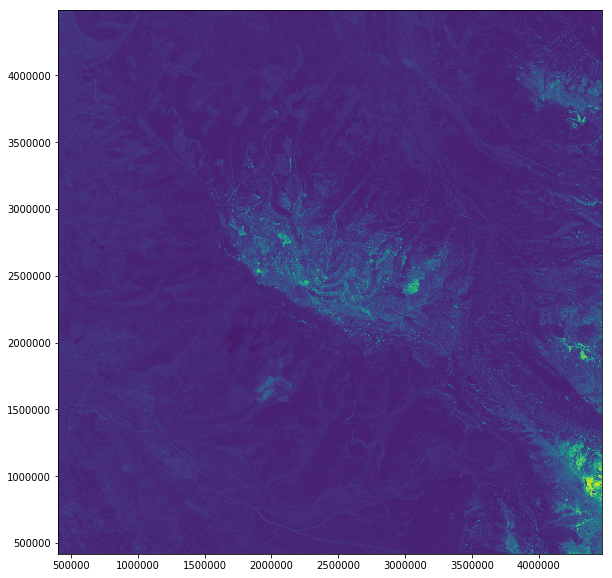

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(arr_S2[0], extent=s_extent);